# Build an autonomous multi-agents workflow to write picture book
## Overall intro
You are running a virtual cartoon studio, the best and creative cartoon studio in the world. Several agents are hired in this studio including a cartoonist, screenwriter, editor, art designer, story illustrator, and translator. All the agents are powered by Amazon Bedrock. You will use a multi-agent workflow to create a illustrated book. You only need to provide a simple idea, and they can transform your idea into an engaging storybook with a twisting plot, featuring well-developed main characters, supporting characters, and antagonists whose personas will remain consistent throughout, accompanied by coherent illustrations and captions. You can create illustrated book from any idea you have.  
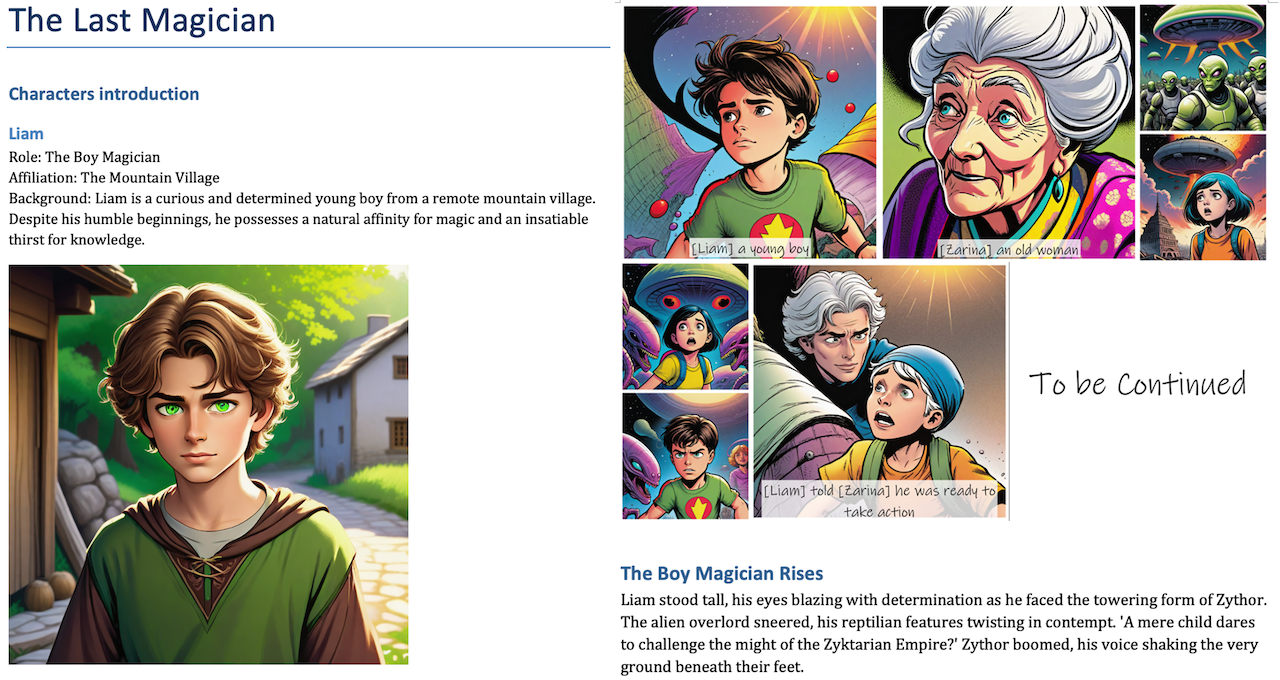

## Part 1
- **Goal**: Write a outline for a story
- In this step, we will create two agents "cartoonist" and "screenwriter", to create an outline.
- The cartoonist create an initial draft, and then ask screenwriter to create the characters. Then cartoonist will revise the outline draft by incooperating the characters.
- The final output are two json files "characters.json" and "outline.json"
- 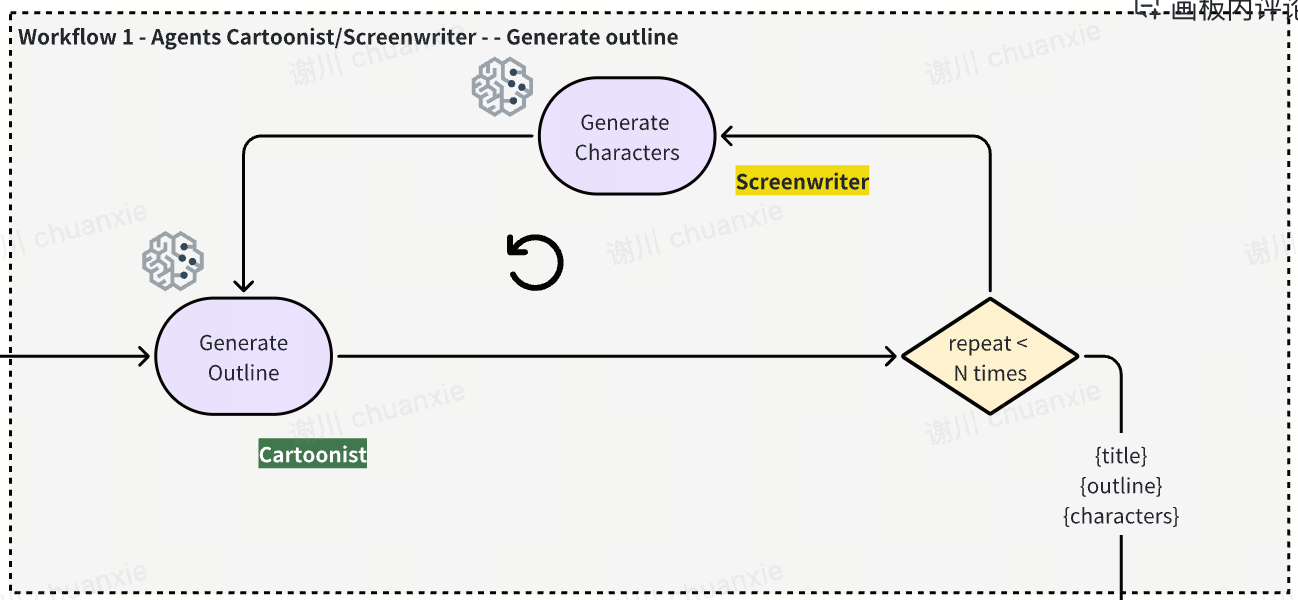

## 1. Install dependecies

In [ ]:
%pip install -Uq langchain_community==0.2.12 langgraph==0.2.14 langchain-aws==0.1.17 langchain_core==0.2.35  python-docx==1.1.2 docx2pdf

## 2. Prerequisites code  
### 2.1 Import Utils functions

- In our case, we need to parse the LLM output to a pydantic object, so will define Structrued Output parser

In [ ]:
from story_agents.llm_utils import CustJsonOuputParser,TextOuputParser,dict_to_obj

- we need to reconstruct the messages send to LLM strictly follow the turns ["user","assistant"]

In [ ]:
from story_agents.llm_utils import convert_message_name,reconstruct_to_claude_messages,swap_roles

### 2.2 Initiailize LLM models

In [ ]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_mistral = ChatBedrock(model_id="mistral.mistral-large-2407-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "max_tokens": 4096,
                               },
                  streaming=False,
                )

llm = llm_mistral

## 3 Agent Roles settings

- In this step, we will create two agents "cartoonist" and "screenwriter", to create an outline.
- The cartoonist create an initial draft, and then ask screenwriter to create the characters. Then cartoonist will revise the outline draft by incooperating the characters.

In [ ]:
#set background information
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""

In [ ]:
role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio.
      """,
      
"screenwriter":  
      company_setting+"""You are a Screenwriter.
Your task is to create a main character and a diverse and distinct group of supporting characters for a new story, based on the provided topic and outline.
For each supporting character, please provide the following:
1. A unique name and role in the story (e.g. sidekick, mentor, rival, etc.)
2. A brief description of their perspective, affiliation, or background related to the story's themes
3. An explanation of what aspects of the story they will focus on or influence
Additionally, think step-by-step about how to make this group of characters distinct and complementary to create an engaging, multifaceted narrative
""",
}

## 4.Create Prompts template and Chains

### 4.1 Define structure output for Outline
- an Outline object consist of a list of chapter objects
- 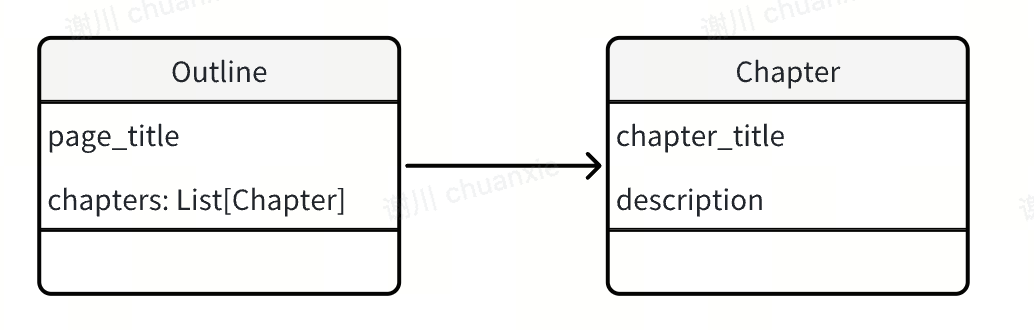

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional,Any
class Chapter(BaseModel):
    chapter_title: str = Field(..., description="Title of the chapter")
    description: str = Field(..., description="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    """
        Outline class to format the LLM output
    """
    page_title: str = Field(..., description="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        description="chapters of the comics book. limits to maximum 5 items",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()

### 4.2 Define prompt template and LLM chain

In [ ]:
from story_agents.prompts import fc_desc
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

In [ ]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config["cartoonist"]+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [ ]:
# define a chain
generate_outline_direct = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)

### 4.3 Input your story topic
-  Please input a story topic as input, you can create your own story with your own topic.
-  Check for Clue 1 if you want to see an example

In [ ]:
topic = input()


- Test for refine generation
- We will parse the output to structured json object, if you encounter JSONDecodeError, you can re-run it

In [ ]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}")],"schema":Outline.schema_json() })
print(outline.as_str)

### 4.4 Create characters

- Create a Character class to format the LLM output
- Characters consist of a main character and serveral supporting characters
- each character has own persona

In [ ]:
class Persona(BaseModel):
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story, such as personality, hobbies, etc..",
    )
    figure: str = Field(
        description="figure representing such as a boy,a girl,a man, a women, a young woman,an old man or etc",
    )
    appearance: str = Field(
        description="appearance, attire of the character in the story.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nBackground: {self.background}\nFigure:{self.figure}\nAppearance: {self.appearance}\n"
    
class Character(BaseModel):
    main_character: Persona = Field(
        description="the main character in the story.",
    )
    
    supporting_character: List[Persona] = Field(
        description="Comprehensive list of supporting characters in the story.",
        min_items=1,
        max_items=3,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.supporting_character])+'\n'+self.main_character.persona

- prompt template 

In [ ]:
gen_character_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
           role_config["screenwriter"]+ fc_desc,
        ),
         MessagesPlaceholder(variable_name="messages")
    ]
)
gen_characters_chain = gen_character_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)

- test for generation

In [ ]:
request = HumanMessage(content=f"Here is the outline:{outline.json()}")
characters = gen_characters_chain.invoke({"messages": [request],"schema":Character.schema_json()})

In [ ]:
print(characters.as_str)

### 4.5 Refine outline by adding characters

- Test for refine generation

In [ ]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}"),
                                                               AIMessage(content=f"Here is the outline draft:{outline.json()}, "),
                                                               HumanMessage(content=f"Here is the characters description:{characters.json()}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific,skip the preamble, put your answer in <answer> ")],
                                          "schema":Outline.schema_json() })

In [ ]:
print(outline.as_str)

## 5 build outline workflow graph
- 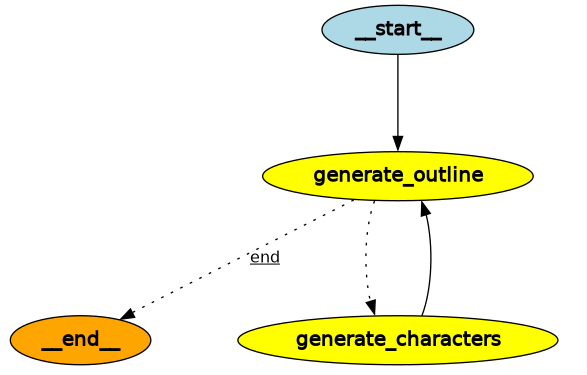

### 5.1 Define node functions

In [ ]:
from story_agents.graph_utils import AgentState, retry_call
from langgraph.graph import StateGraph, END
async def generate_outline(state:AgentState):
    """
    Generate outline

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_outline---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    generate_outline_chain = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=False) | RunnableLambda(dict_to_obj).bind(target=Outline)
    name = "cartoonist"
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(messages)
    outline = await retry_call(generate_outline_chain,{"messages": messages,"schema":Outline.schema_json() })
    response = AIMessage(content=f"Here is the outline: \n{outline.json()}",name=name)
    return {"messages":[response],"env_var":{**env_var,"outline":outline}}

async def generate_characters(state:AgentState):
    """
    Generate characters

    Args:
        state (AgentState): The current state

    Returns:
         dict: The updated state
    """
    print("---generate_characters---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    name = 'screenwriter'
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(state['messages'])
    gen_characters_chain = gen_character_prompt | llm| CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=Character)
    characters = await retry_call(gen_characters_chain,{"messages": messages,"schema":Character.schema_json() })
    print("characters",characters)
    response = AIMessage(content=f"Here is the characters description:\n{characters.json()}.\n Your task is to rewrite the outline draft for a story based on the outline draft. Please incorporate all the characters in the story, and keep the outline be comprehensive and specific ",name=name)

    return {"messages":[response],"env_var":{**env_var,"characters":characters}}

### 5.2 Add conditional edge, it repeat the flow untill reaches the max turns

In [ ]:
MAX_TURNS = 2
def should_repeat_outline(state: AgentState):
    messages = state['messages']
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print('messages:',num_responses)
    if num_responses > MAX_TURNS:
        return 'end'
    else:
        return 'generate_characters'

### 5.3 build workflow

In [ ]:
outline_graph = StateGraph(AgentState)
outline_graph.add_node("generate_outline",generate_outline)
outline_graph.add_node("generate_characters",generate_characters)
outline_graph.set_entry_point("generate_outline")
outline_graph.add_edge("generate_characters", "generate_outline")
outline_graph.add_conditional_edges("generate_outline",
                                   should_repeat_outline,
                                   {
                                       'end':END,
                                       'generate_characters':'generate_characters'
                                   }
                                   )
outline_workflow = outline_graph.compile()

- print out the graph

In [ ]:
from IPython.display import Image
Image(outline_workflow.get_graph().draw_mermaid_png())

- Run generation
- We will parse the output to structured json object, if you encounter JSONDecodeError, you can re-run it

In [ ]:
steps = []
init_state = {
    "env_var":{"topic":topic},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}
async for event in outline_workflow.astream(init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

#### retrieve outline and characters objects from the final step

In [ ]:
outline = steps[-1]['generate_outline']['env_var']['outline']

In [ ]:
characters = steps[-1]['generate_outline']['env_var']['characters']

In [ ]:
print(outline.as_str)

In [ ]:
print(characters.as_str)

In [ ]:
print(outline.as_str)

#### Save to local files

In [ ]:
with open('characters.json','w') as f:
    f.write(characters.json())

In [ ]:
with open('outline.json','w') as f:
    f.write(outline.json())

### 6. In the file browser Panel, open the 'outline.json' with text editor, then copy and paste to the answer box in the JAM Task.

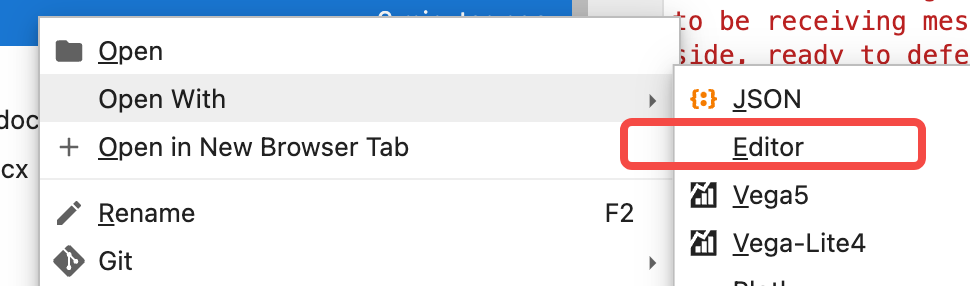